## 导入库

In [1]:
import keras
#from PIL import Image
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
#from PIL import Image
from keras.utils import to_categorical
import random

## 数据预处理

In [2]:
train_per = 0.6
val_per = 0.2
test_per = 1 - train_per - val_per
print("train_per:", train_per)
print("val_per:", val_per)
print("test_per:", test_per)

train_per: 0.6
val_per: 0.2
test_per: 0.2


In [3]:
image1 = [None] * 1573
label1 = [None] * 1573
image2 = [None] * 1573
label2 = [None] * 1573
#创建数据集列表
data_amount = 0

n = 0

#insulting
for i in range(1,1571):
    #
    data_place_one = './data_training_20240217/insulting/' + str(i) + '.jpg'
    #print(data_place_one)
    img_2 = cv2.imread(data_place_one)
    if img_2 is not None:
        n += 1
        data_amount += 1
        image1[i-1] = np.array(img_2)
        label1[i-1] = 1
    else:
        pass
        #print("Failed to load image. or not exist")

#uninsulting
for i in range(1,1571):
    data_place_one = './data_training_20240217/uninsulting/' + str(i) + '.jpg'
    #print(data_place_one)
    img_2 = cv2.imread(data_place_one)
    if img_2 is not None:
        n += 1
        data_amount += 1
        image2[i-1] = np.array(img_2)
        label2[i-1] = 0
    else:
        pass
        #print("Failed to load image. or not exist")
#print(img)

label = label1+label2
image = image1+image2

#删除空值
label = [x for x in label if x != None]
image = [x for x in image if np.any(x)]


combined_list = list(zip(label, image))
# 打乱元组列表
random.shuffle(combined_list)
# 恢复两个列表
label, image = zip(*combined_list)

train_num = round(len(image) * train_per)
val_num = round(len(image) * val_per)
test_num = round(len(image) * test_per)
print("train_num:",train_num)
print("val_num:",val_num)
print("test_num:",test_num)

val_image = image[train_num : train_num + val_num]
val_label = label[train_num : train_num + val_num]
test_image = image[train_num + val_num :]
test_label = label[train_num + val_num :]
train_image = image[: train_num]
train_label = label[: train_num]

train_num: 1884
val_num: 628
test_num: 628


In [4]:
train_label = np.array(train_label)
train_image = np.array(train_image)
val_label = np.array(val_label)
val_image = np.array(val_image)
test_label = np.array(test_label)
test_image = np.array(test_image)
#print(train_label.shape)
# 将标签数据进行one-hot编码
train_label_encoded = to_categorical(train_label, num_classes=2)
test_label_encoded = to_categorical(test_label, num_classes=2)
val_label_encoded = to_categorical(val_label, num_classes=2)

## 模型构建

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

#### 残差投影

In [21]:
def C1(x):
    x = layers.Conv2D(filters=8, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    return x

In [22]:
def residual_block(x, filters_size1, filters_size2, filters_size3, stride = 1):
    residual = x
    x = layers.Conv2D(filters = filters_size1, kernel_size=1, activation="relu", padding="same")(x)
    x = layers.Conv2D(filters = filters_size2, kernel_size=3, activation="relu", strides = stride, padding="same")(x)
    x = layers.Conv2D(filters = filters_size3, kernel_size=1, activation="relu", padding="same")(x)

    residual = layers.Conv2D(filters = filters_size3, kernel_size=1, activation="relu", strides = stride, padding="same")(residual)

    x = layers.add([x,residual])
    return x



In [23]:
inputs_emoji = keras.Input(shape=(128,128,3))
#x = data_augmentation(inputs_emoji)
#x = layers.Rescaling(1./255)(x)
x = C1(inputs_emoji)
x = residual_block(x, 8,8,32,stride = 2)
x = residual_block(x, 16,16,64,stride = 2)
x = residual_block(x, 32,32,128,stride = 2)
x = layers.Flatten()(x)
outputs_result = layers.Dense(2,activation="sigmoid")(x)
model = keras.Model(inputs = inputs_emoji,outputs = outputs_result)

In [24]:
model.summary()
keras.utils.plot_model(model,show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 128, 128, 8)          224       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 8)            0         ['conv2d_13[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_14 (Conv2D)          (None, 64, 64, 8)            72        ['max_pooling2d_1[0][0]'

In [25]:
callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='./model/model_HGCN_20240405t1600.h5',
        monitor="val_loss",
        save_best_only=True
    )
]

In [26]:
model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

## 模型训练

In [15]:
epochs_ = 100
history = model.fit(train_image,
        train_label_encoded,
        epochs=epochs_,
        batch_size=100,
        #callbacks=callbacks_list,
        validation_data=(val_image,val_label_encoded)
        )

Epoch 1/100
19/19 [==============================] - 7s 316ms/step - loss: 11.2222 - accuracy: 0.5409 - val_loss: 2.0466 - val_accuracy: 0.5127
Epoch 2/100
19/19 [==============================] - 6s 318ms/step - loss: 2.3930 - accuracy: 0.5499 - val_loss: 0.7177 - val_accuracy: 0.6131
Epoch 3/100
19/19 [==============================] - 9s 457ms/step - loss: 1.2852 - accuracy: 0.5685 - val_loss: 0.6223 - val_accuracy: 0.6290
Epoch 4/100
19/19 [==============================] - 10s 545ms/step - loss: 0.9514 - accuracy: 0.5839 - val_loss: 0.6053 - val_accuracy: 0.7054
Epoch 5/100
19/19 [==============================] - 10s 550ms/step - loss: 0.6986 - accuracy: 0.6407 - val_loss: 0.5903 - val_accuracy: 0.6481
Epoch 6/100
19/19 [==============================] - 10s 553ms/step - loss: 0.6368 - accuracy: 0.6741 - val_loss: 0.5723 - val_accuracy: 0.7102
Epoch 7/100
19/19 [==============================] - 10s 546ms/step - loss: 0.6334 - accuracy: 0.6762 - val_loss: 0.5761 - val_accuracy: 0

In [16]:
model.save('./model/model_HGCN_20240405t1600.h5')

C:\Users\Victor\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 模型评估

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


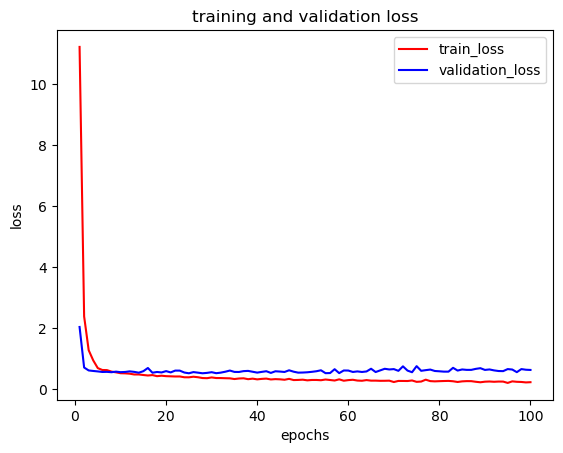

In [17]:
history_dir = history.history
print(history_dir.keys())
loss_values = history_dir["loss"]
accuracy_values = history_dir["accuracy"]
val_loss_values = history_dir["val_loss"]
val_accuracy_values = history_dir["val_accuracy"]
x_epochs = range(1,epochs_+1)
plt.plot(x_epochs,loss_values,"r",label = "train_loss")
plt.plot(x_epochs,val_loss_values,"b",label = "validation_loss")
plt.title("training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

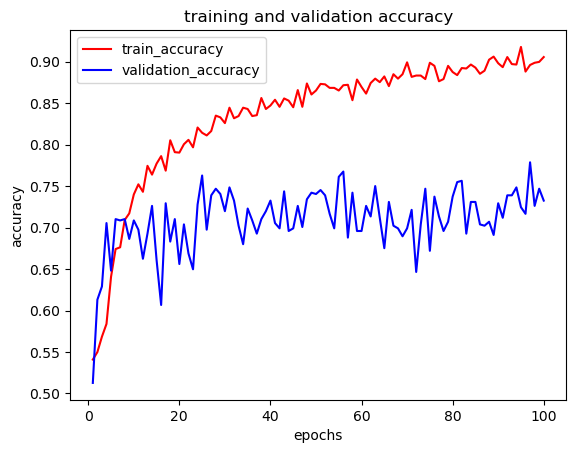

In [18]:
plt.plot(x_epochs,accuracy_values,"r",label = "train_accuracy")
plt.plot(x_epochs,val_accuracy_values,"b",label = "validation_accuracy")
plt.title("training and validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [19]:
results = model.evaluate(test_image,test_label_encoded)
print("test_loss:",results[0],"; test_accuracy:",results[1])

y = np.argmax(model.predict(test_image[:]),axis=1)
print('原始：',y[:20])
print('结果：',test_label[:20])

20/20 [==============================] - 1s 25ms/step - loss: 0.6142 - accuracy: 0.7373
test_loss: 0.6141758561134338 ; test_accuracy: 0.737261176109314
20/20 [==============================] - 1s 24ms/step
原始： [0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1]
结果： [0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 0]
